# **Feature Engineering**

In [264]:
# Data manipulation & visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature engineering & preprocessing
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Model training & evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    classification_report,
    make_scorer
)

# Feature selection & interpretation
from sklearn.feature_selection import mutual_info_classif
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, mutual_info_classif  
import shap

from sklearn.preprocessing import PowerTransformer 

# Function

In [265]:
def balanced_recall_accuracy(y_true, y_pred, alpha=0.7):
    recall_class1 = recall_score(y_true, y_pred, pos_label=1)
    accuracy = accuracy_score(y_true, y_pred)
    return alpha * recall_class1 + (1 - alpha) * accuracy  # Weighted sum

In [266]:
def plot_correlation_matrix(df, title='Correlation Matrix', figsize=(10, 8), cmap='coolwarm'):
    """
    Plots a correlation matrix for the given DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        title (str): The title of the plot.
        figsize (tuple): The size of the figure.
        cmap (str): The colormap to use.

    Returns:
        None
    """
    plt.figure(figsize=figsize)
    sns.heatmap(df.corr(),
            annot=True,
            cmap='coolwarm',
            center=0)
    plt.title(title)
    plt.show()

In [267]:
def plot_pairplot(df, hue=None, title='Pairplot', figsize=(10, 8)):
    """
    Plots a pairplot for the given DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        hue (str): The column name to use for color coding.
        title (str): The title of the plot.
        figsize (tuple): The size of the figure.

    Returns:
        None
    """
    sns.pairplot(df, hue=hue)
    plt.suptitle(title, y=1.02)
    plt.show()

In [268]:
def plot_feature_distributions(dataframe, n_cols=3, fig_width=15, row_height=4, 
                              kde=True, color='skyblue', title_prefix='Distribution of '):
    """
    Plots distribution histograms for all columns in a DataFrame in a grid layout.
    
    Parameters:
    -----------
    dataframe : pandas.DataFrame
        The DataFrame containing the data to plot
    n_cols : int (default=3)
        Number of columns in the subplot grid
    fig_width : int (default=15)
        Width of the entire figure in inches
    row_height : int (default=4)
        Height of each row in inches
    kde : bool (default=True)
        Whether to show kernel density estimate
    color : str (default='skyblue')
        Color for the histograms
    title_prefix : str (default='Distribution of ')
        Prefix for each subplot title
    """
    # Calculate grid dimensions
    n_features = len(dataframe.columns)
    n_rows = (n_features - 1) // n_cols + 1
    
    # Create figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, n_rows * row_height))
    fig.tight_layout(pad=3.0)
    
    # Flatten axes array for easy iteration
    axes = axes.flatten()
    
    # Plot histograms for each feature
    for i, column in enumerate(dataframe.columns):
        sns.histplot(data=dataframe, x=column, kde=kde, color=color, ax=axes[i])
        axes[i].set_title(f'{title_prefix}{column}')
        axes[i].set_xlabel('')
        
        # Rotate x-tick labels if they're too long
        if len(dataframe[column].unique()) < 10:  # For categorical features
            axes[i].tick_params(axis='x', rotation=45)
    
    # Hide any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.show()

# Import Data

In [269]:
# Load each sheet into separate DataFrames
# Define the file path in Google Drive
file_path = 'Dataset2_Needs.xls'

# Load each sheet into separate DataFrames
needs_df = pd.read_excel(file_path, sheet_name='Needs')

# Drop ID column as it's not needed for analysis
needs_df = needs_df.drop('ID', axis=1)

# Encode the data

In [270]:
needs_df = pd.get_dummies(needs_df, columns=['Gender'], prefix='Gender')
needs_df.rename(columns={"Gender_0" : "Male", "Gender_1" : "Female"}, inplace=True)

# Accumulation Investment

In [271]:
df_accumulation = needs_df.copy()
df_accumulation = df_accumulation.drop(columns=['IncomeInvestment'])
df_accumulation.head()

,Age,FamilyMembers,FinancialEducation,RiskPropensity,Income,Wealth,AccumulationInvestment,Male,Female
0,60,2,0.228685,0.233355,68.181525,53.260067,1,True,False
1,78,2,0.358916,0.170911,21.807595,135.550048,0,True,False
2,33,2,0.317515,0.249703,23.252747,66.303678,1,False,True
3,69,4,0.767685,0.654597,166.189034,404.997689,1,False,True
4,58,3,0.429719,0.349039,21.186723,58.911930,0,True,False


In [272]:
df_accumulation.corr(numeric_only=True)[['AccumulationInvestment']]

,AccumulationInvestment
Age,-0.013512
FamilyMembers,0.066606
FinancialEducation,0.067965
RiskPropensity,0.068420
Income,0.300324
Wealth,0.138393
AccumulationInvestment,1.000000
Male,0.010783
Female,-0.010783


In [273]:
df_accumulation.head()

,Age,FamilyMembers,FinancialEducation,RiskPropensity,Income,Wealth,AccumulationInvestment,Male,Female
0,60,2,0.228685,0.233355,68.181525,53.260067,1,True,False
1,78,2,0.358916,0.170911,21.807595,135.550048,0,True,False
2,33,2,0.317515,0.249703,23.252747,66.303678,1,False,True
3,69,4,0.767685,0.654597,166.189034,404.997689,1,False,True
4,58,3,0.429719,0.349039,21.186723,58.911930,0,True,False


## Comparison Basis

In [274]:
X = df_accumulation.drop(columns=['AccumulationInvestment'])  # Features
y = df_accumulation['AccumulationInvestment']                # Target (0 or 1)
X_train_basis, X_test_basis, y_train_basis, y_test_basis = train_test_split(X, y, test_size=0.2, random_state=42)

# Model without feature selection
# Initialize and train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_basis, y_train_basis)

# Make predictions
y_pred = rf.predict(X_test_basis)

# Compute metrics
recall = recall_score(y_test_basis, y_pred)
precision = precision_score(y_test_basis, y_pred)

# Print results
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test_basis, y_pred))

Recall: 0.7573
Precision: 0.8341

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       489
           1       0.83      0.76      0.79       511

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000



## Feature Selection

In [275]:
feature_combinations = {
    'Wealth / Income': lambda df: df['Wealth'] * df['Income'],
    'RiskPropensity * Wealth': lambda df: df['RiskPropensity'] * df['Wealth'],
    'FinancialEducation * RiskPropensity': lambda df: df['FinancialEducation'] * df['RiskPropensity'],
    'Age * RiskPropensity': lambda df: df['Age'] * df['RiskPropensity'],
    'Age * FinancialEducation': lambda df: df['Age'] * df['FinancialEducation'],
    'Age / FamilyMembers': lambda df: df['Age'] / df['FamilyMembers'],
    'Income / FamilyMembers': lambda df: df['Income'] / df['FamilyMembers'],
    'Wealth / Family': lambda df: (df['Wealth']) / df['FamilyMembers'],
    'Wealth / Age': lambda df: df['Wealth'] / df['Age'],
    'RiskPropensity * Income': lambda df: df['RiskPropensity'] * df['Income']
}

# Create new features based on the combinations defined above
for feature_name, func in feature_combinations.items():
    df_accumulation[feature_name] = func(df_accumulation)

In [276]:
df_accumulation.head()

,Age,FamilyMembers,FinancialEducation,RiskPropensity,Income,Wealth,AccumulationInvestment,Male,Female,Wealth / Income,RiskPropensity * Wealth,FinancialEducation * RiskPropensity,Age * RiskPropensity,Age * FinancialEducation,Age / FamilyMembers,Income / FamilyMembers,Wealth / Family,Wealth / Age,RiskPropensity * Income
0,60,2,0.228685,0.233355,68.181525,53.260067,1,True,False,3631.352562,12.428484,0.053365,14.001279,13.721082,30.000000,34.090763,26.630033,0.887668,15.910476
1,78,2,0.358916,0.170911,21.807595,135.550048,0,True,False,2956.020562,23.167050,0.061343,13.331090,27.995462,39.000000,10.903798,67.775024,1.737821,3.727167
2,33,2,0.317515,0.249703,23.252747,66.303678,1,False,True,1541.742689,16.556230,0.079285,8.240200,10.478003,16.500000,11.626374,33.151839,2.009202,5.806282
3,69,4,0.767685,0.654597,166.189034,404.997689,1,False,True,67306.174793,265.110404,0.502525,45.167215,52.970273,17.250000,41.547259,101.249422,5.869532,108.786897
4,58,3,0.429719,0.349039,21.186723,58.911930,0,True,False,1248.150713,20.562566,0.149989,20.244267,24.923723,19.333333,7.062241,19.637310,1.015723,7.394994


## Step 1: SelectKbest over mutual information

In [277]:
X = df_accumulation.drop(columns=['AccumulationInvestment'])  # Features
y = df_accumulation['AccumulationInvestment']                # Target (0 or 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X.head()

,Age,FamilyMembers,FinancialEducation,RiskPropensity,Income,Wealth,Male,Female,Wealth / Income,RiskPropensity * Wealth,FinancialEducation * RiskPropensity,Age * RiskPropensity,Age * FinancialEducation,Age / FamilyMembers,Income / FamilyMembers,Wealth / Family,Wealth / Age,RiskPropensity * Income
0,60,2,0.228685,0.233355,68.181525,53.260067,True,False,3631.352562,12.428484,0.053365,14.001279,13.721082,30.000000,34.090763,26.630033,0.887668,15.910476
1,78,2,0.358916,0.170911,21.807595,135.550048,True,False,2956.020562,23.167050,0.061343,13.331090,27.995462,39.000000,10.903798,67.775024,1.737821,3.727167
2,33,2,0.317515,0.249703,23.252747,66.303678,False,True,1541.742689,16.556230,0.079285,8.240200,10.478003,16.500000,11.626374,33.151839,2.009202,5.806282
3,69,4,0.767685,0.654597,166.189034,404.997689,False,True,67306.174793,265.110404,0.502525,45.167215,52.970273,17.250000,41.547259,101.249422,5.869532,108.786897
4,58,3,0.429719,0.349039,21.186723,58.911930,True,False,1248.150713,20.562566,0.149989,20.244267,24.923723,19.333333,7.062241,19.637310,1.015723,7.394994


In [278]:
# Select top 10-12 features based on mutual information  
selector = SelectKBest(mutual_info_classif, k=12)  
X_filtered = selector.fit_transform(X_train, y_train)  
selected_features = X_train.columns[selector.get_support()]

In [279]:
print("Selected features: ", selected_features)

Selected features:  Index(['RiskPropensity', 'Income', 'Wealth', 'Wealth / Income',
       'RiskPropensity * Wealth', 'FinancialEducation * RiskPropensity',
       'Age * RiskPropensity', 'Age * FinancialEducation',
       'Income / FamilyMembers', 'Wealth / Family', 'Wealth / Age',
       'RiskPropensity * Income'],
      dtype='object')


## Step 2: Forward Feature Selection

In [280]:
X = df_accumulation[selected_features]
y = df_accumulation['AccumulationInvestment']                # Target (0 or 1)
X_train_FFS, X_test_FFS, y_train_FFS, y_test_FFS = train_test_split(X, y, test_size=0.2, random_state=42)
X.head()

,RiskPropensity,Income,Wealth,Wealth / Income,RiskPropensity * Wealth,FinancialEducation * RiskPropensity,Age * RiskPropensity,Age * FinancialEducation,Income / FamilyMembers,Wealth / Family,Wealth / Age,RiskPropensity * Income
0,0.233355,68.181525,53.260067,3631.352562,12.428484,0.053365,14.001279,13.721082,34.090763,26.630033,0.887668,15.910476
1,0.170911,21.807595,135.550048,2956.020562,23.167050,0.061343,13.331090,27.995462,10.903798,67.775024,1.737821,3.727167
2,0.249703,23.252747,66.303678,1541.742689,16.556230,0.079285,8.240200,10.478003,11.626374,33.151839,2.009202,5.806282
3,0.654597,166.189034,404.997689,67306.174793,265.110404,0.502525,45.167215,52.970273,41.547259,101.249422,5.869532,108.786897
4,0.349039,21.186723,58.911930,1248.150713,20.562566,0.149989,20.244267,24.923723,7.062241,19.637310,1.015723,7.394994


In [281]:
custom_scorer = make_scorer(balanced_recall_accuracy, alpha=0.7)  # Tune alpha!

# Initialize SFS with the custom scorer
sfs = SFS(
    RandomForestClassifier(random_state=42),
    k_features="best",
    forward=True,
    scoring="recall",  # Use the custom scorer
    cv=StratifiedKFold(3),  # Stratified K-Folds cross-validator
    n_jobs=-1,
    verbose=2
)

# Fit on training data
sfs.fit(X_train_FFS, y_train_FFS)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    8.4s remaining:   25.3s
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    9.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    9.4s finished

[2025-04-08 18:41:53] Features: 1/12 -- score: 0.5698296836982969[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  11 | elapsed:    4.3s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    5.3s finished

[2025-04-08 18:41:59] Features: 2/12 -- score: 0.7026763990267639[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    5.5s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.5s finished

[2025-04-08 18:42:04] Features: 3/12 -- score: 0.7211678832116788[Parallel(n_jobs=-1)]: Using backe

SequentialFeatureSelector(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                          estimator=RandomForestClassifier(random_state=42),
                          k_features=(1, 12), n_jobs=-1, scoring='recall',
                          verbose=2)

In [282]:
# Get the best subset's performance
best_subset_key = list(sfs.subsets_.keys())[-1]  # The last key is the best subset
best_subset = sfs.subsets_[best_subset_key]

print("Best features:", sfs.k_feature_names_)
print("CV Recall (custom scorer):", best_subset['avg_score'])
print("CV Accuracy:", np.mean(best_subset['cv_scores']))  # Average across folds

Best features: ('Income', 'Wealth', 'Wealth / Income', 'FinancialEducation * RiskPropensity', 'Age * FinancialEducation', 'Income / FamilyMembers', 'Wealth / Family', 'Wealth / Age')
CV Recall (custom scorer): 0.7265206812652067
CV Accuracy: 0.7265206812652067


In [283]:
# Model without feature selection
selected_features = list(sfs.k_feature_names_)
rf.fit(X_train[selected_features], y_train)

# Make predictions
y_pred = rf.predict(X_test[selected_features])

# Compute metrics
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Print results
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Recall: 0.7319
Precision: 0.8166

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       489
           1       0.82      0.73      0.77       511

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000



## Step 3: Exhaustive Feature Selection

## Cleaning the new dataset

In [284]:
df_accumulation = df_accumulation[selected_features + ["AccumulationInvestment"]]
df_accumulation.head()

,Income,Wealth,Wealth / Income,FinancialEducation * RiskPropensity,Age * FinancialEducation,Income / FamilyMembers,Wealth / Family,Wealth / Age,AccumulationInvestment
0,68.181525,53.260067,3631.352562,0.053365,13.721082,34.090763,26.630033,0.887668,1
1,21.807595,135.550048,2956.020562,0.061343,27.995462,10.903798,67.775024,1.737821,0
2,23.252747,66.303678,1541.742689,0.079285,10.478003,11.626374,33.151839,2.009202,1
3,166.189034,404.997689,67306.174793,0.502525,52.970273,41.547259,101.249422,5.869532,1
4,21.186723,58.911930,1248.150713,0.149989,24.923723,7.062241,19.637310,1.015723,0


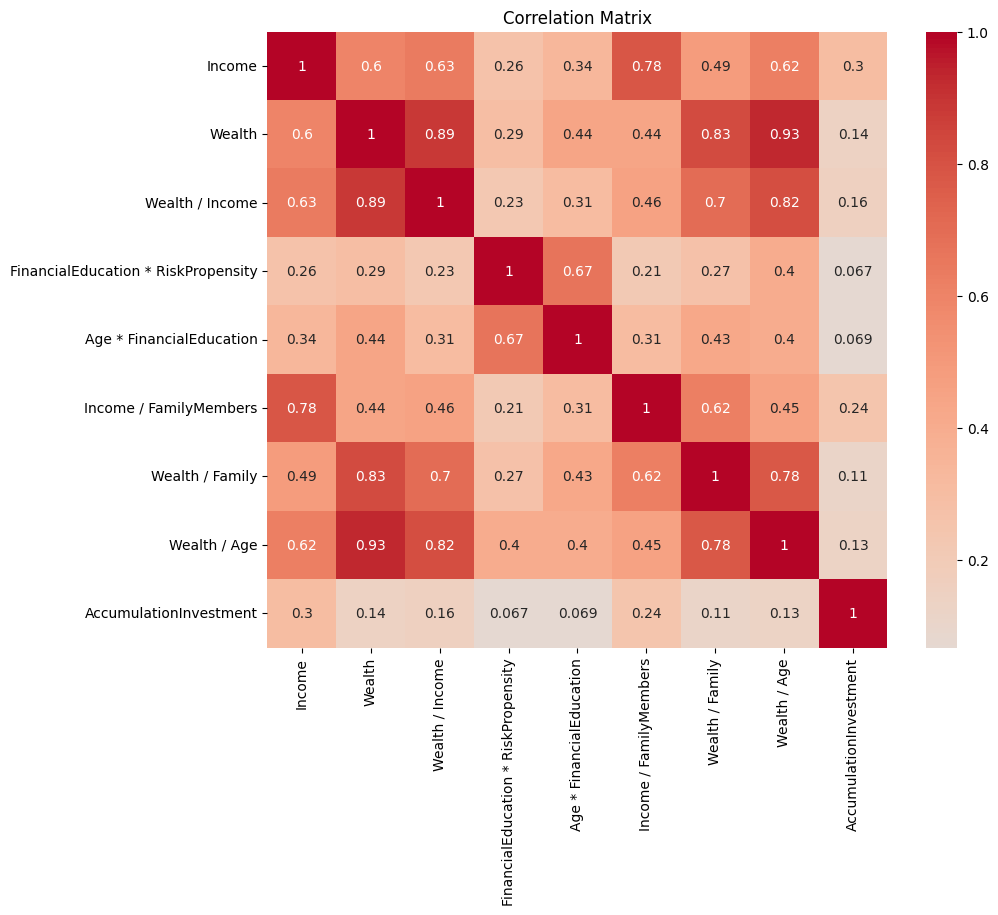

In [285]:
plot_correlation_matrix(df_accumulation)

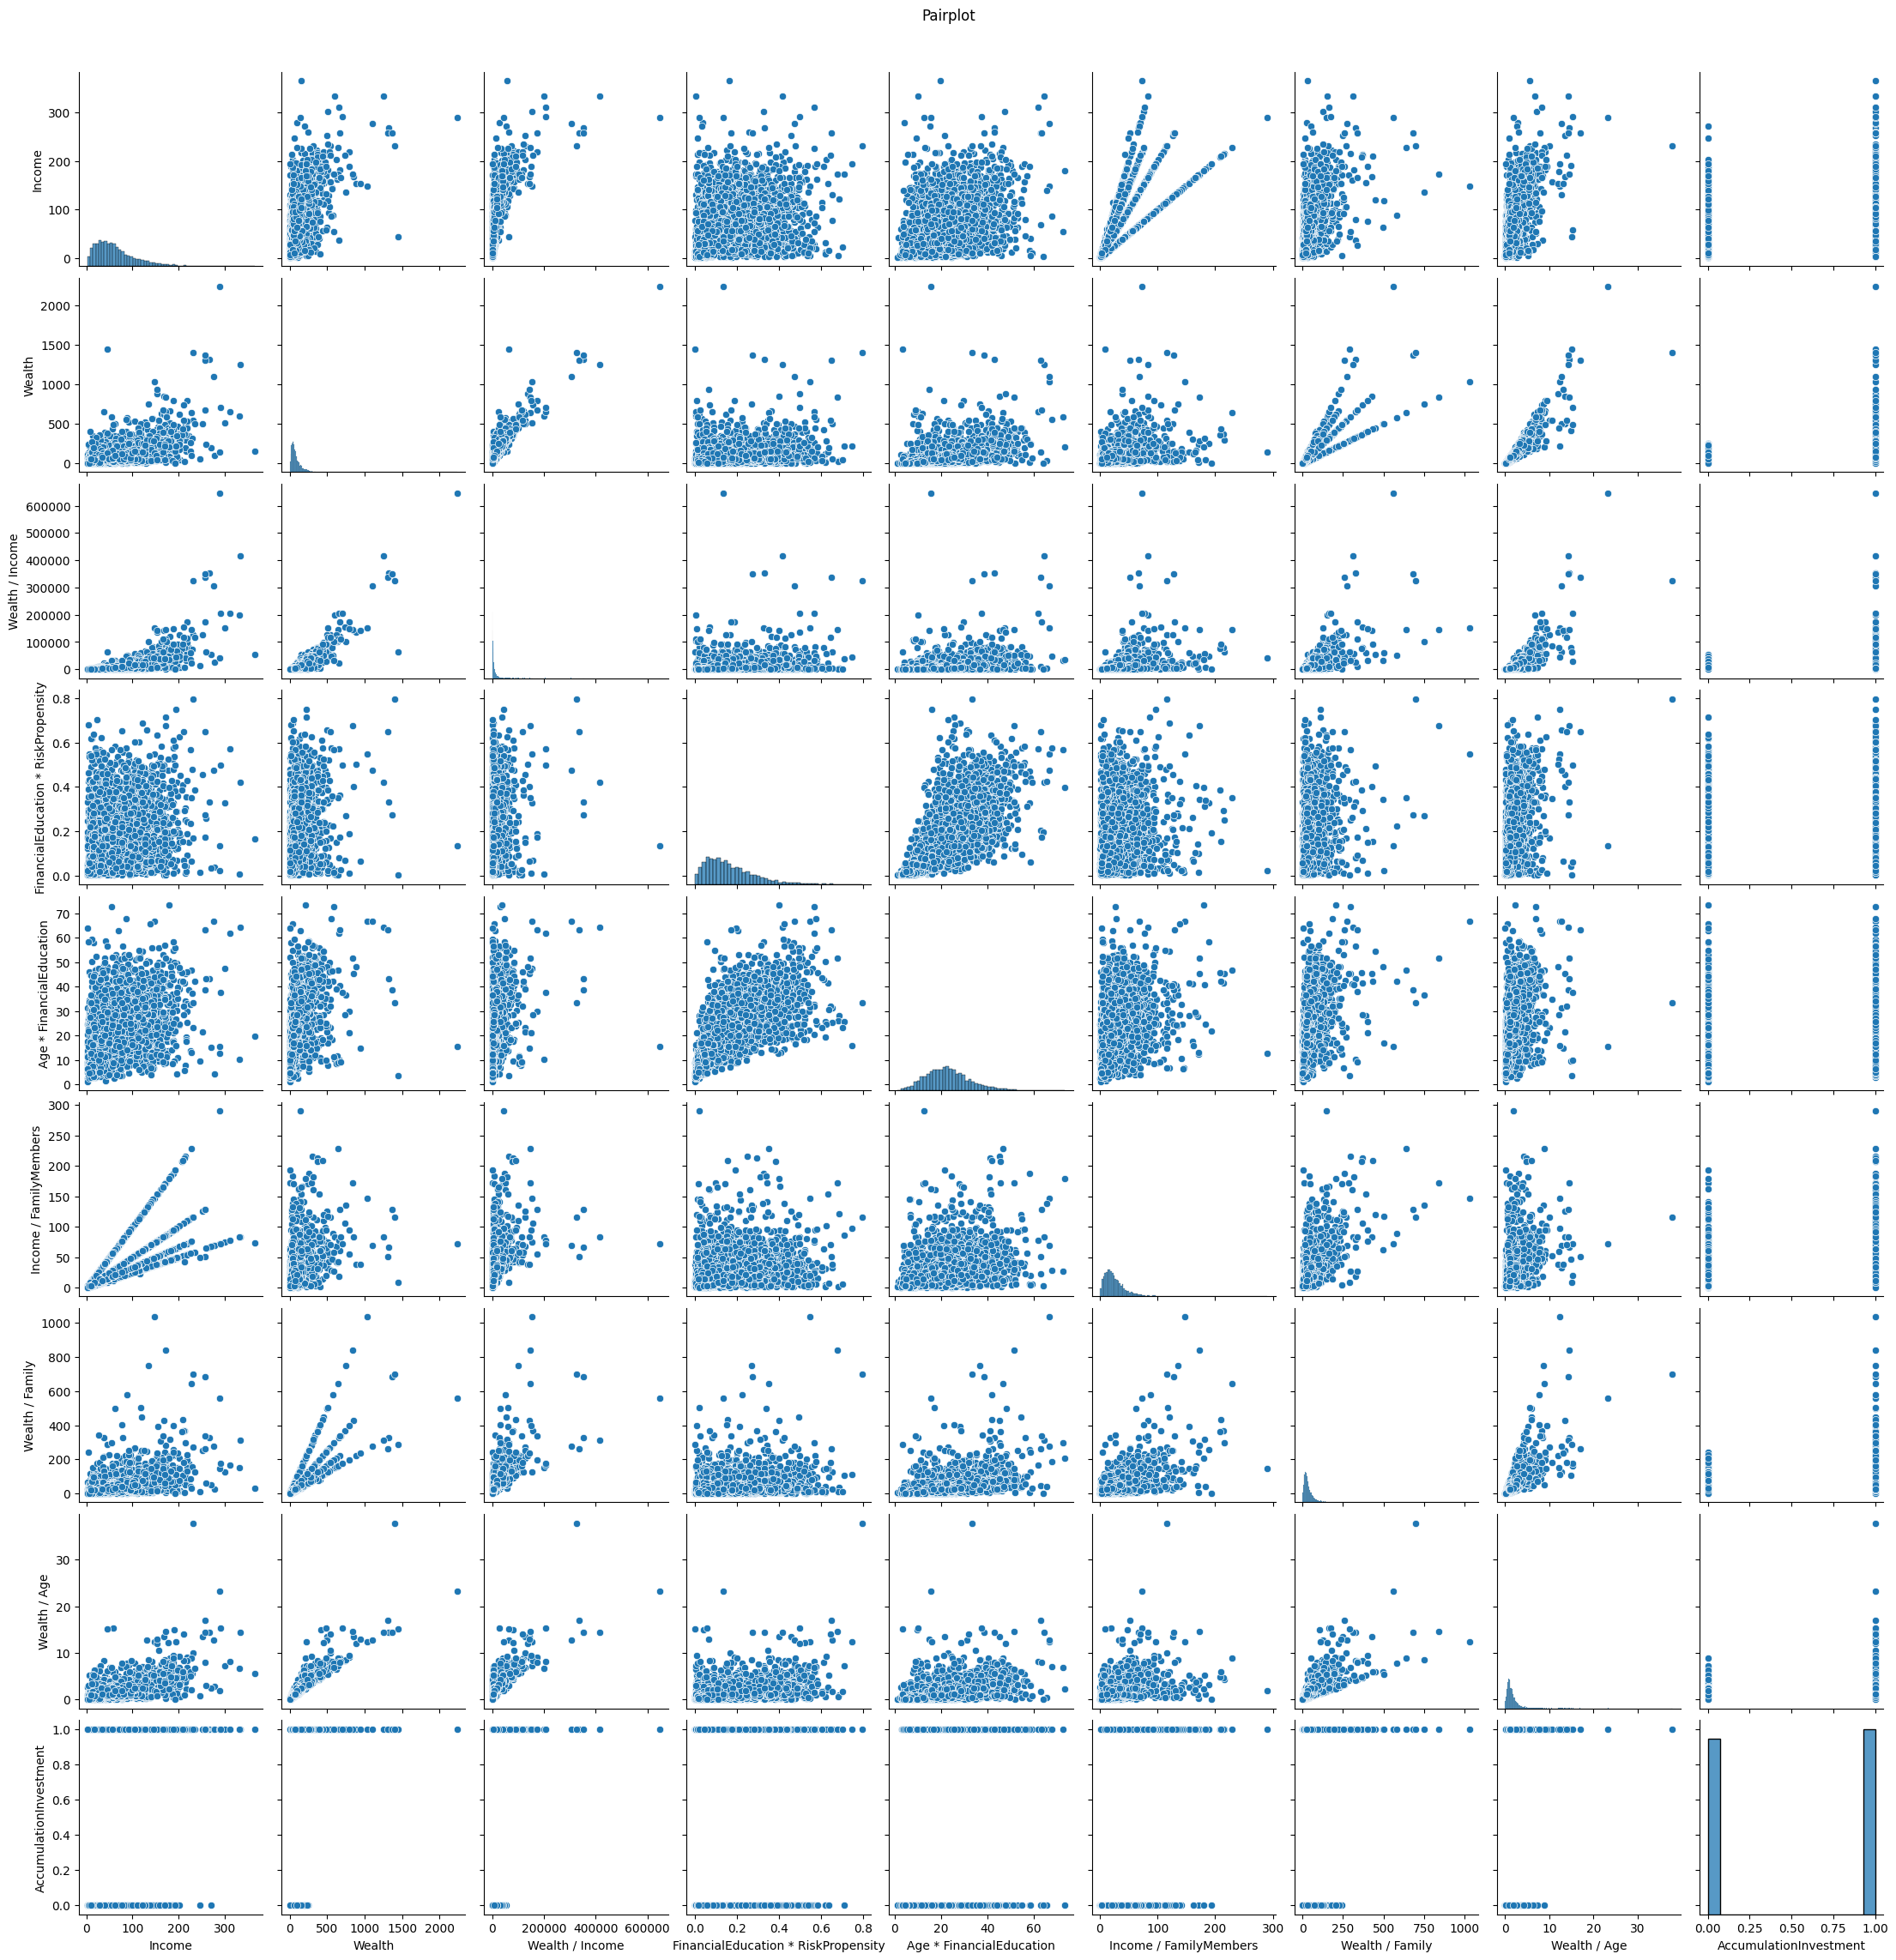

In [286]:
plot_pairplot(df_accumulation)

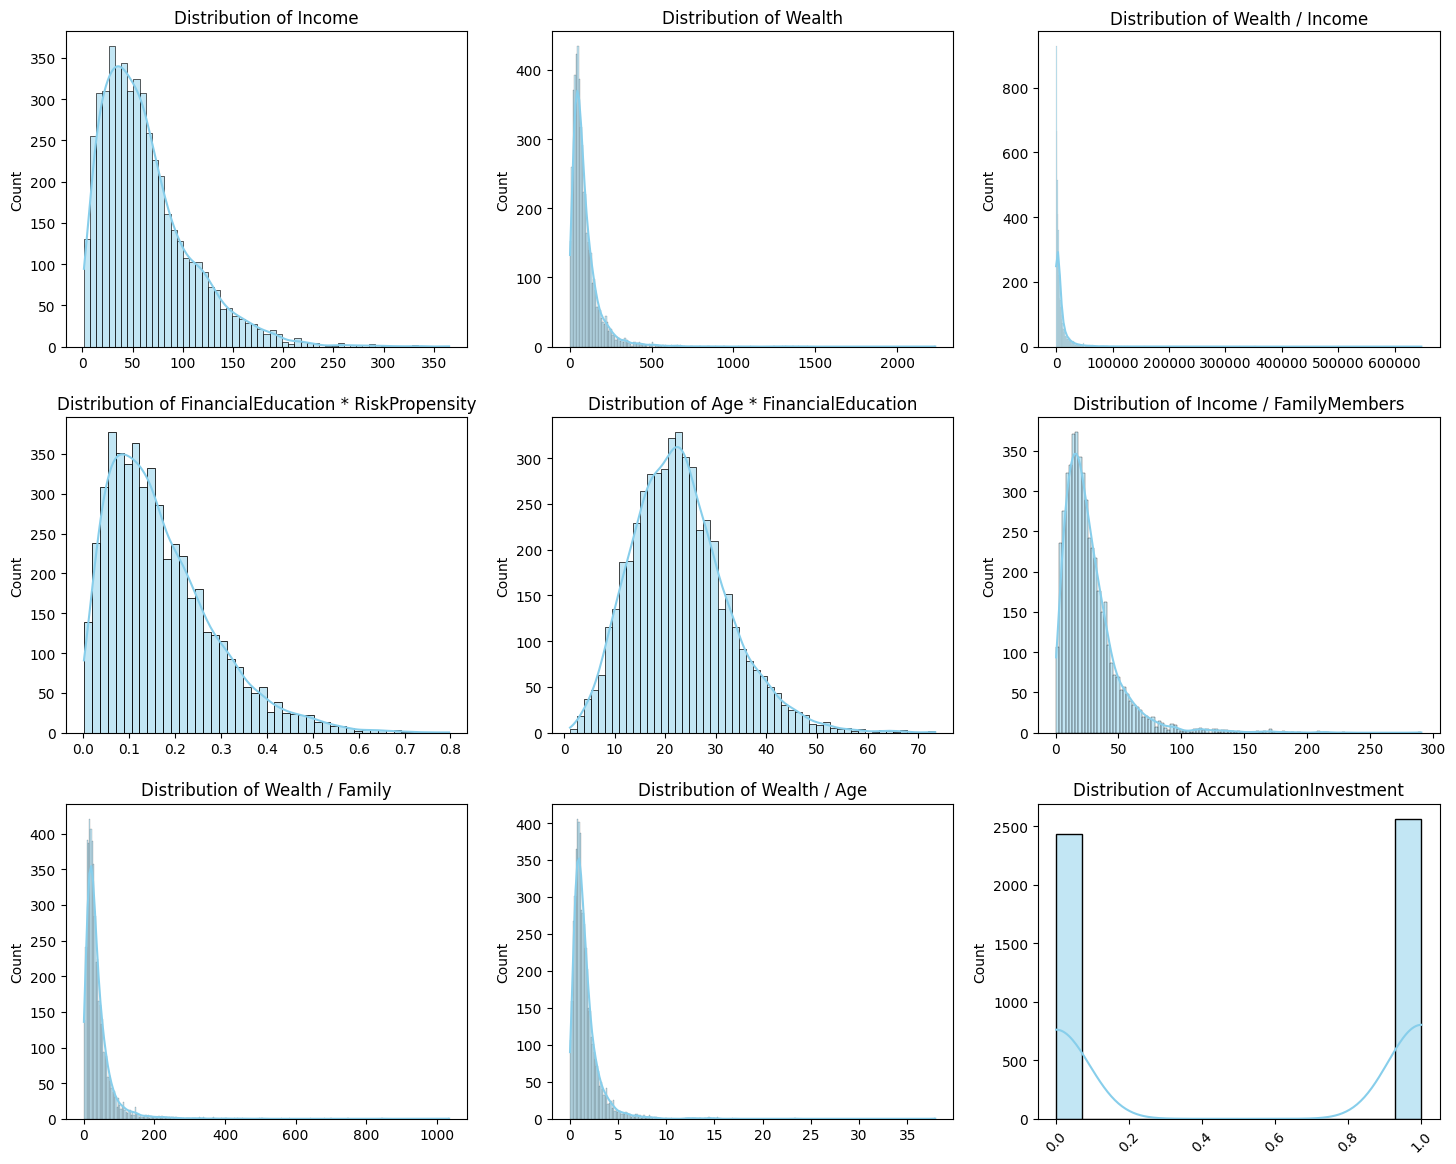

In [287]:
plot_feature_distributions(df_accumulation)

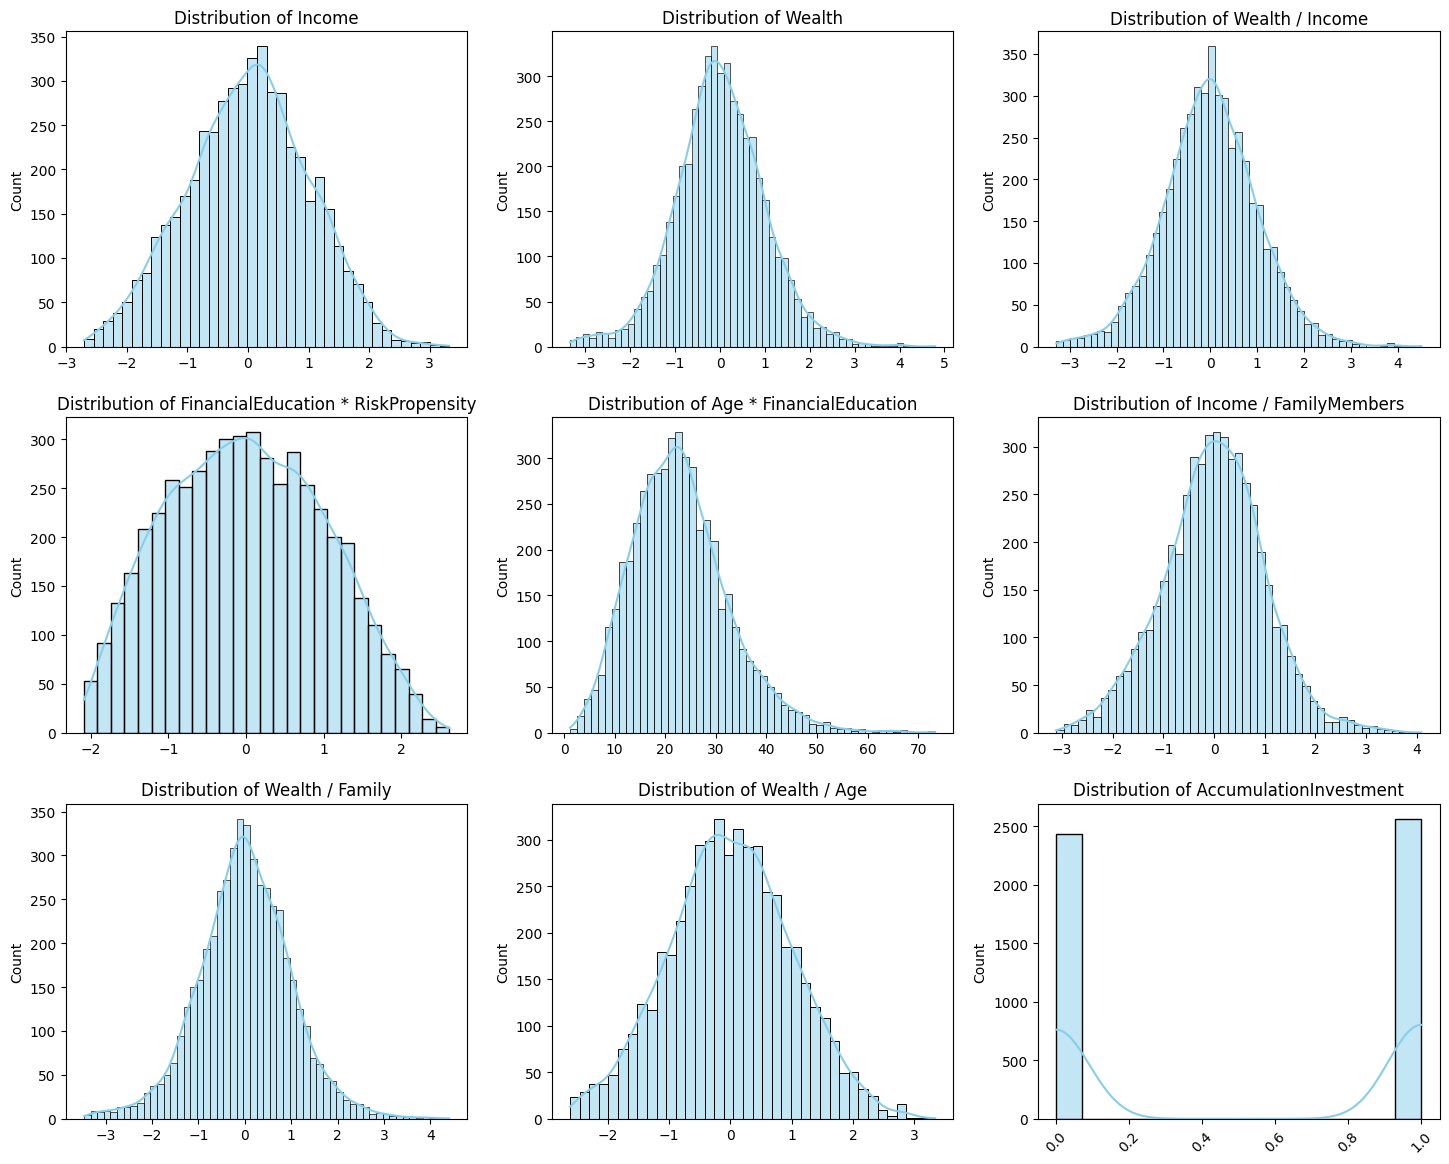

In [288]:
df_accumulation_transformed = df_accumulation.copy()
pt = PowerTransformer(method='yeo-johnson')
columns_yeo_johnson = ["FinancialEducation * RiskPropensity", "Income", "Wealth / Age", "Wealth", "Wealth / Income", "Income / FamilyMembers", "Wealth / Family", "FinancialEducation * RiskPropensity"]
df_accumulation_transformed[columns_log] = np.log1p(df_accumulation_transformed[columns_log])
df_accumulation_transformed[columns_sqrt] = np.log1p(df_accumulation_transformed[columns_sqrt])
df_accumulation_transformed[columns_yeo_johnson] = pt.fit_transform(df_accumulation_transformed[columns_yeo_johnson])
plot_feature_distributions(df_accumulation_transformed)

In [ ]:
scaler = RobustScaler()
numeric_cols = df_accumulation_transformed.select_dtypes(include=['number']).columns.difference(["AccumulationInvestment"])
df_accumulation_transformed = df_accumulation_transformed.copy()
df_accumulation_transformed[numeric_cols] = scaler.fit_transform(df_accumulation_transformed[numeric_cols])

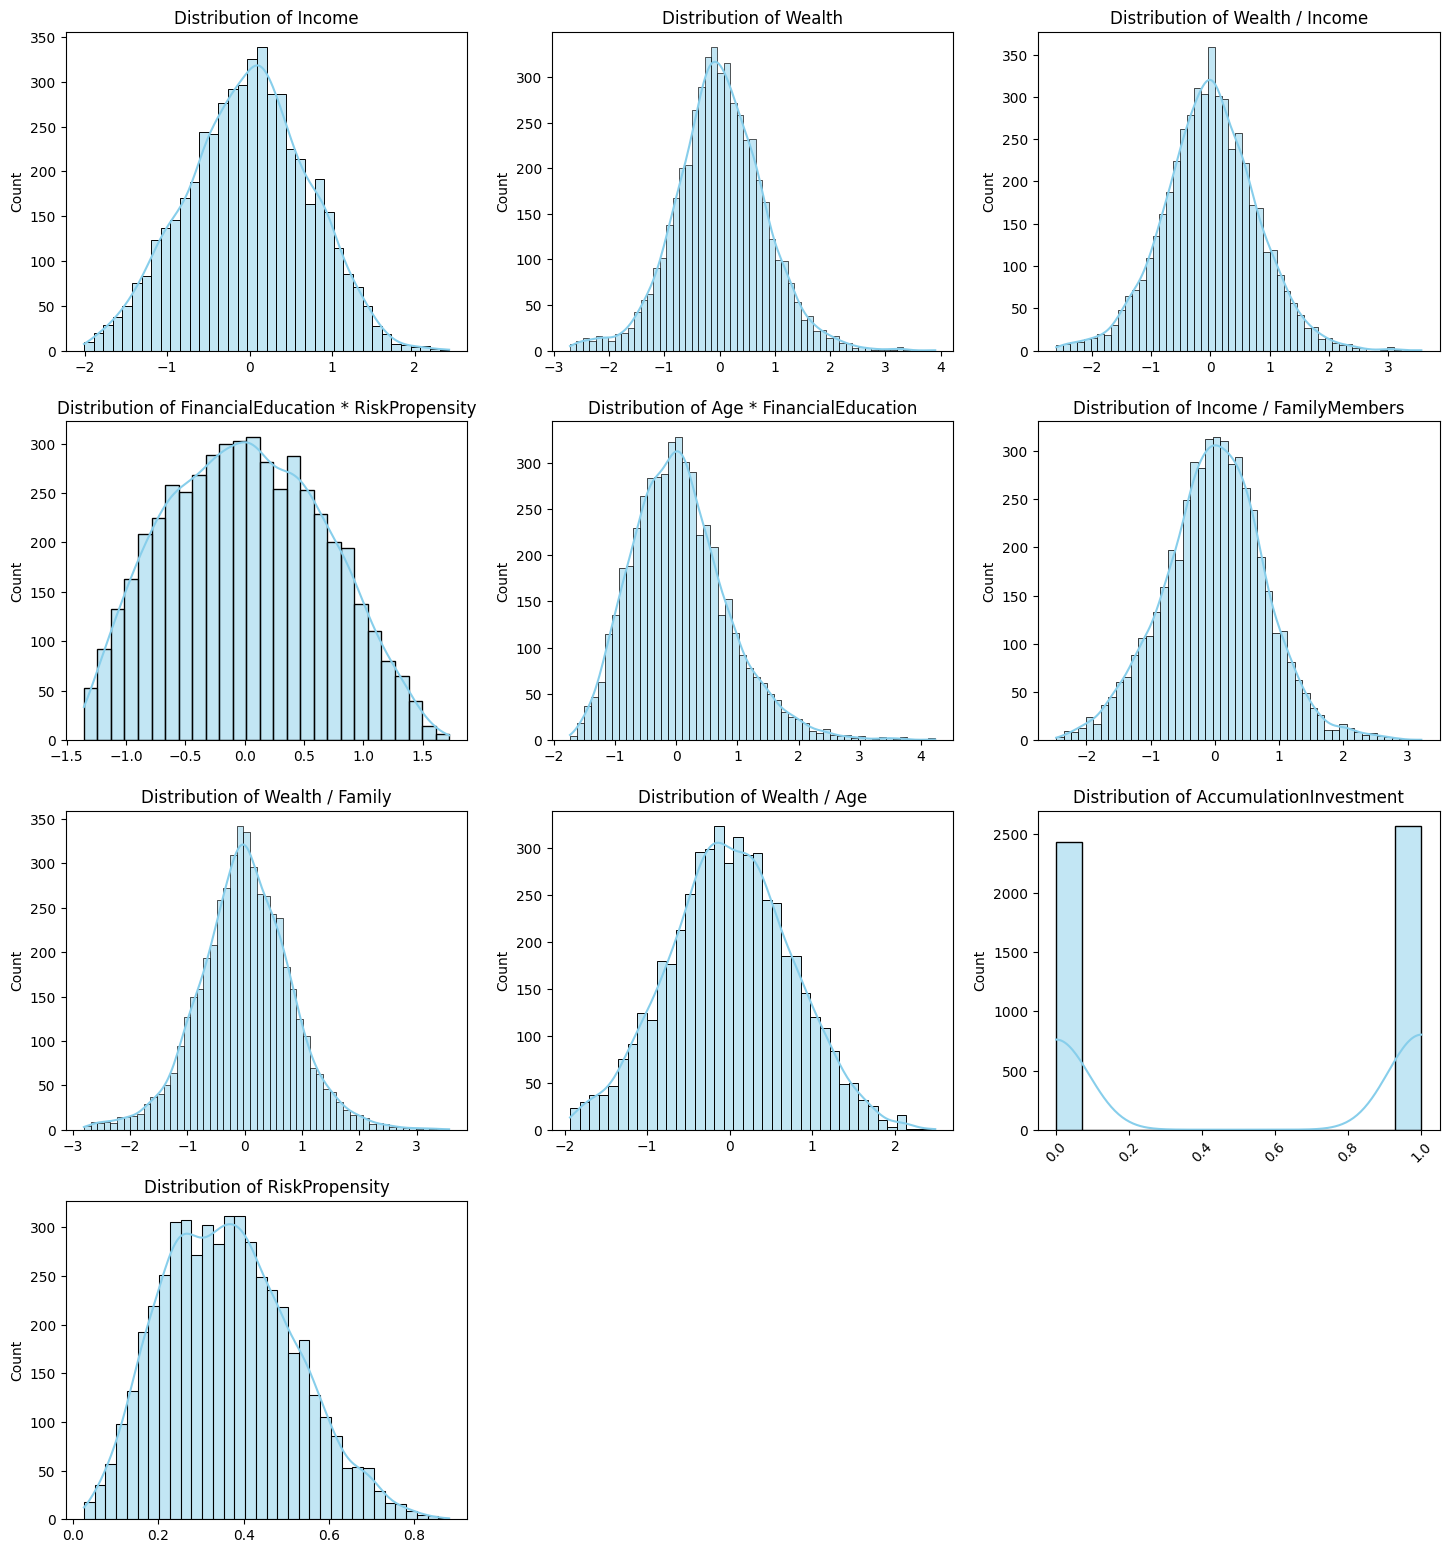

In [290]:
plot_feature_distributions(df_accumulation_transformed)

In [291]:
df_accumulation_transformed.to_excel(
    "accumulation_transformed.xlsx",
    index=False,
    sheet_name="ProcessedData"  # Optional: customize sheet name
)

In [292]:
# Create a dictionary for the new column names
column_rename_map = {
    'Wealth / Income': 'wealth_to_income_ratio',
    'FinancialEducation * RiskPropensity': 'fin_risk_score',
    'Age * FinancialEducation': 'age_weighted_fin_knowledge',
    'Income / FamilyMembers': 'per_capita_income',
    'Wealth / Family': 'per_capita_wealth',
    'Wealth / Age': 'wealth_by_age'
}

# Rename the columns in your DataFrame
df_accumulation_transformed = df_accumulation_transformed.rename(columns=column_rename_map)
df_accumulation_transformed.head()

,Income,Wealth,wealth_to_income_ratio,fin_risk_score,age_weighted_fin_knowledge,per_capita_income,per_capita_wealth,wealth_by_age,AccumulationInvestment,RiskPropensity
0,0.252633,-0.193803,0.030280,-0.755576,-0.699967,0.482826,-0.024232,-0.327442,1,0.233355
1,-0.793303,0.681875,-0.076322,-0.675873,0.481023,-0.659570,0.848880,0.372903,0,0.170911
2,-0.743314,0.003208,-0.399848,-0.506646,-0.968283,-0.601155,0.176872,0.525688,1,0.249703
3,1.307327,1.828994,1.796406,1.350346,2.547312,0.702960,1.234882,1.528684,1,0.654597
4,-0.815463,-0.103730,-0.500511,0.045931,0.226883,-1.035291,-0.299397,-0.191280,0,0.349039


# Income Investment

In [293]:
df_income = needs_df.copy()
df_income = df_income.drop(columns=['AccumulationInvestment'])
df_income.head()

,Age,FamilyMembers,FinancialEducation,RiskPropensity,Income,Wealth,IncomeInvestment,Male,Female
0,60,2,0.228685,0.233355,68.181525,53.260067,0,True,False
1,78,2,0.358916,0.170911,21.807595,135.550048,1,True,False
2,33,2,0.317515,0.249703,23.252747,66.303678,0,False,True
3,69,4,0.767685,0.654597,166.189034,404.997689,1,False,True
4,58,3,0.429719,0.349039,21.186723,58.911930,0,True,False


In [294]:
df_income.corr(numeric_only=True)[['IncomeInvestment']]

,IncomeInvestment
Age,0.334249
FamilyMembers,0.041936
FinancialEducation,0.087424
RiskPropensity,0.063324
Income,0.208907
Wealth,0.384246
IncomeInvestment,1.000000
Male,0.013703
Female,-0.013703


In [295]:
df_income.head()

,Age,FamilyMembers,FinancialEducation,RiskPropensity,Income,Wealth,IncomeInvestment,Male,Female
0,60,2,0.228685,0.233355,68.181525,53.260067,0,True,False
1,78,2,0.358916,0.170911,21.807595,135.550048,1,True,False
2,33,2,0.317515,0.249703,23.252747,66.303678,0,False,True
3,69,4,0.767685,0.654597,166.189034,404.997689,1,False,True
4,58,3,0.429719,0.349039,21.186723,58.911930,0,True,False


## Comparison Basis

In [296]:
X = df_income.drop(columns=['IncomeInvestment'])  # Features
y = df_income['IncomeInvestment']                # Target (0 or 1)
X_train_basis, X_test_basis, y_train_basis, y_test_basis = train_test_split(X, y, test_size=0.2, random_state=42)

# Model without feature selection
# Initialize and train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_basis, y_train_basis)

# Make predictions
y_pred = rf.predict(X_test_basis)

# Compute metrics
recall = recall_score(y_test_basis, y_pred)
precision = precision_score(y_test_basis, y_pred)

# Print results
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test_basis, y_pred))

Recall: 0.5906
Precision: 0.8459

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.93      0.85       619
           1       0.85      0.59      0.70       381

    accuracy                           0.80      1000
   macro avg       0.82      0.76      0.77      1000
weighted avg       0.81      0.80      0.79      1000



## Feature Selection

In [297]:
feature_combinations_income = {
    # Financial Capacity Features
    'Wealth / Income': lambda df: df['Wealth'] * df['Income'],
    'RiskPropensity * Wealth': lambda df: df['RiskPropensity'] * df['Wealth'],
    'Income / FamilyMembers': lambda df: df['Income'] / (df['FamilyMembers']),
    
    # Financial Sophistication Features
    'FinancialEducation * RiskPropensity': lambda df: df['FinancialEducation'] * df['RiskPropensity'],
    'FinancialEducation * Wealth': lambda df: df['FinancialEducation'] * df['Wealth'],
    
    # Life Stage Features
    'Wealth / Age': lambda df: df['Wealth'] / (df['Age'] ),
    'Wealth / FamilyMembers': lambda df: df['Wealth'] / (df['FamilyMembers']),
    
    # Risk Features
    'RiskPropensity * Income': lambda df: df['RiskPropensity'] * df['Income'],
    'RiskPropensity * FinancialEducation * Income': lambda df: df['RiskPropensity'] * df['FinancialEducation'] * df['Income'],
    
    # Protection Features
    'Age * FamilyMembers / Income': lambda df: (df['Age'] * df['FamilyMembers']) / (df['Income'])
}

# Create new features based on the combinations defined above
for feature_name, func in feature_combinations.items():
    df_income[feature_name] = func(df_income)

In [298]:
df_income.head()

,Age,FamilyMembers,FinancialEducation,RiskPropensity,Income,Wealth,IncomeInvestment,Male,Female,Wealth / Income,RiskPropensity * Wealth,FinancialEducation * RiskPropensity,Age * RiskPropensity,Age * FinancialEducation,Age / FamilyMembers,Income / FamilyMembers,Wealth / Family,Wealth / Age,RiskPropensity * Income
0,60,2,0.228685,0.233355,68.181525,53.260067,0,True,False,3631.352562,12.428484,0.053365,14.001279,13.721082,30.000000,34.090763,26.630033,0.887668,15.910476
1,78,2,0.358916,0.170911,21.807595,135.550048,1,True,False,2956.020562,23.167050,0.061343,13.331090,27.995462,39.000000,10.903798,67.775024,1.737821,3.727167
2,33,2,0.317515,0.249703,23.252747,66.303678,0,False,True,1541.742689,16.556230,0.079285,8.240200,10.478003,16.500000,11.626374,33.151839,2.009202,5.806282
3,69,4,0.767685,0.654597,166.189034,404.997689,1,False,True,67306.174793,265.110404,0.502525,45.167215,52.970273,17.250000,41.547259,101.249422,5.869532,108.786897
4,58,3,0.429719,0.349039,21.186723,58.911930,0,True,False,1248.150713,20.562566,0.149989,20.244267,24.923723,19.333333,7.062241,19.637310,1.015723,7.394994


## Step 1: SelectKbest over mutual information

In [299]:
X = df_income.drop(columns=['IncomeInvestment'])  # Features
y = df_income['IncomeInvestment']                # Target (0 or 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X.head()

,Age,FamilyMembers,FinancialEducation,RiskPropensity,Income,Wealth,Male,Female,Wealth / Income,RiskPropensity * Wealth,FinancialEducation * RiskPropensity,Age * RiskPropensity,Age * FinancialEducation,Age / FamilyMembers,Income / FamilyMembers,Wealth / Family,Wealth / Age,RiskPropensity * Income
0,60,2,0.228685,0.233355,68.181525,53.260067,True,False,3631.352562,12.428484,0.053365,14.001279,13.721082,30.000000,34.090763,26.630033,0.887668,15.910476
1,78,2,0.358916,0.170911,21.807595,135.550048,True,False,2956.020562,23.167050,0.061343,13.331090,27.995462,39.000000,10.903798,67.775024,1.737821,3.727167
2,33,2,0.317515,0.249703,23.252747,66.303678,False,True,1541.742689,16.556230,0.079285,8.240200,10.478003,16.500000,11.626374,33.151839,2.009202,5.806282
3,69,4,0.767685,0.654597,166.189034,404.997689,False,True,67306.174793,265.110404,0.502525,45.167215,52.970273,17.250000,41.547259,101.249422,5.869532,108.786897
4,58,3,0.429719,0.349039,21.186723,58.911930,True,False,1248.150713,20.562566,0.149989,20.244267,24.923723,19.333333,7.062241,19.637310,1.015723,7.394994


In [300]:
# Select top 10-12 features based on mutual information  
selector = SelectKBest(mutual_info_classif, k=15)  
X_filtered = selector.fit_transform(X_train, y_train)  
selected_features = X_train.columns[selector.get_support()]

In [301]:
print("Selected features: ", selected_features)

Selected features:  Index(['Age', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity',
       'Income', 'Wealth', 'Wealth / Income', 'RiskPropensity * Wealth',
       'Age * RiskPropensity', 'Age * FinancialEducation',
       'Age / FamilyMembers', 'Income / FamilyMembers', 'Wealth / Family',
       'Wealth / Age', 'RiskPropensity * Income'],
      dtype='object')


## Step 2: Forward Feature Selection

In [302]:
X = df_income[selected_features]
y = df_income['IncomeInvestment']                # Target (0 or 1)
X_train_FFS, X_test_FFS, y_train_FFS, y_test_FFS = train_test_split(X, y, test_size=0.2, random_state=42)
X.head()

,Age,FamilyMembers,FinancialEducation,RiskPropensity,Income,Wealth,Wealth / Income,RiskPropensity * Wealth,Age * RiskPropensity,Age * FinancialEducation,Age / FamilyMembers,Income / FamilyMembers,Wealth / Family,Wealth / Age,RiskPropensity * Income
0,60,2,0.228685,0.233355,68.181525,53.260067,3631.352562,12.428484,14.001279,13.721082,30.000000,34.090763,26.630033,0.887668,15.910476
1,78,2,0.358916,0.170911,21.807595,135.550048,2956.020562,23.167050,13.331090,27.995462,39.000000,10.903798,67.775024,1.737821,3.727167
2,33,2,0.317515,0.249703,23.252747,66.303678,1541.742689,16.556230,8.240200,10.478003,16.500000,11.626374,33.151839,2.009202,5.806282
3,69,4,0.767685,0.654597,166.189034,404.997689,67306.174793,265.110404,45.167215,52.970273,17.250000,41.547259,101.249422,5.869532,108.786897
4,58,3,0.429719,0.349039,21.186723,58.911930,1248.150713,20.562566,20.244267,24.923723,19.333333,7.062241,19.637310,1.015723,7.394994


In [303]:
custom_scorer = make_scorer(balanced_recall_accuracy, alpha=0.7)  # Tune alpha!

# Initialize SFS with the custom scorer
sfs = SFS(
    RandomForestClassifier(random_state=42),
    k_features="best",
    forward=True,
    scoring="recall",  # Use the custom scorer
    cv=StratifiedKFold(4),  # Stratified K-Folds cross-validator
    n_jobs=-1,
    verbose=2
)

# Fit on training data
sfs.fit(X_train_FFS, y_train_FFS)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    5.0s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    7.3s finished

[2025-04-08 18:43:22] Features: 1/15 -- score: 0.5334973620129869[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:    3.8s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    6.7s finished

[2025-04-08 18:43:28] Features: 2/15 -- score: 0.5992069128787878[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    3.7s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  11 out of  13 | elapsed:    4.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    6.5s finished

[2025-04-08 18:43:35] Features: 3/15 -- score: 0.6070092667748918[Parallel(n_jobs=-1)]: Using backe

SequentialFeatureSelector(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
                          estimator=RandomForestClassifier(random_state=42),
                          k_features=(1, 15), n_jobs=-1, scoring='recall',
                          verbose=2)

In [304]:
# Get the best subset's performance
best_subset_key = list(sfs.subsets_.keys())[-1]  # The last key is the best subset
best_subset = sfs.subsets_[best_subset_key]

print("Best features:", sfs.k_feature_names_)
print("CV Recall (custom scorer):", best_subset['avg_score'])
print("CV Accuracy:", np.mean(best_subset['cv_scores']))  # Average across folds

Best features: ('Age', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity', 'Income', 'Wealth', 'RiskPropensity * Wealth', 'Income / FamilyMembers')
CV Recall (custom scorer): 0.6070109577922078
CV Accuracy: 0.6070109577922078


In [305]:
# Model without feature selection
selected_features = list(sfs.k_feature_names_)
rf.fit(X_train[selected_features], y_train)

# Make predictions
y_pred = rf.predict(X_test[selected_features])

# Compute metrics
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Print results
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Recall: 0.5879
Precision: 0.8390

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.93      0.85       619
           1       0.84      0.59      0.69       381

    accuracy                           0.80      1000
   macro avg       0.81      0.76      0.77      1000
weighted avg       0.81      0.80      0.79      1000



## Step 3: Exhaustive Feature Selection

## Cleaning the new dataset

In [306]:
df_income = df_income[selected_features + ["IncomeInvestment"]]
df_income.head()

,Age,FamilyMembers,FinancialEducation,RiskPropensity,Income,Wealth,RiskPropensity * Wealth,Income / FamilyMembers,IncomeInvestment
0,60,2,0.228685,0.233355,68.181525,53.260067,12.428484,34.090763,0
1,78,2,0.358916,0.170911,21.807595,135.550048,23.167050,10.903798,1
2,33,2,0.317515,0.249703,23.252747,66.303678,16.556230,11.626374,0
3,69,4,0.767685,0.654597,166.189034,404.997689,265.110404,41.547259,1
4,58,3,0.429719,0.349039,21.186723,58.911930,20.562566,7.062241,0


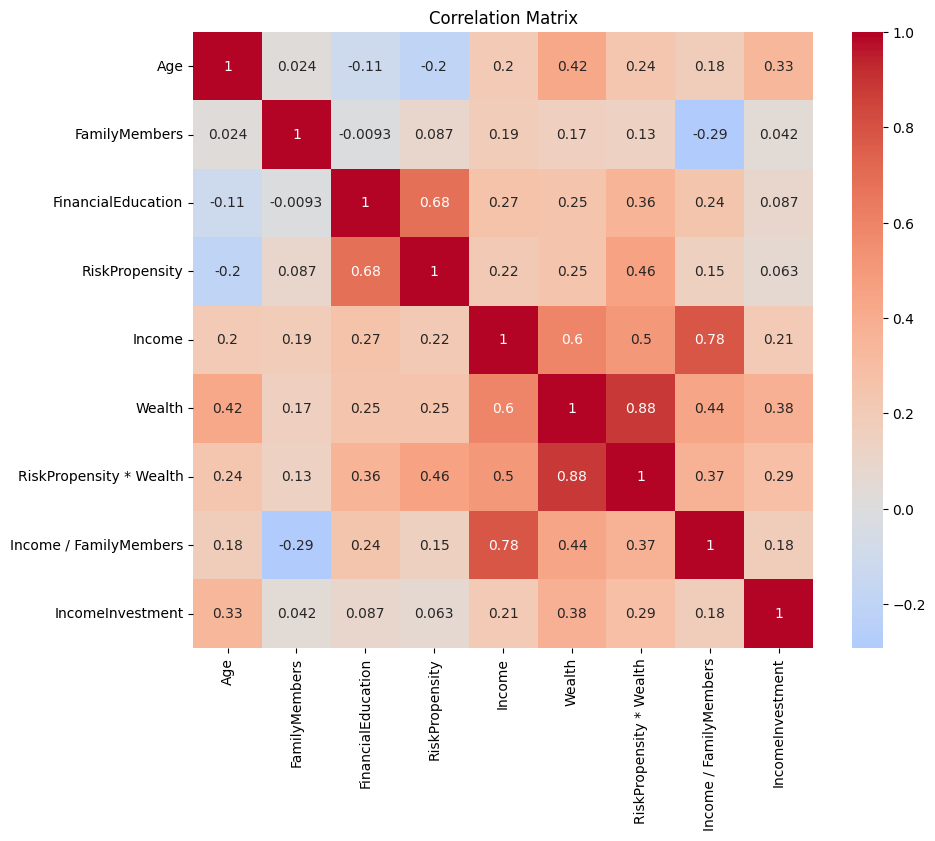

In [307]:
plot_correlation_matrix(df_income)

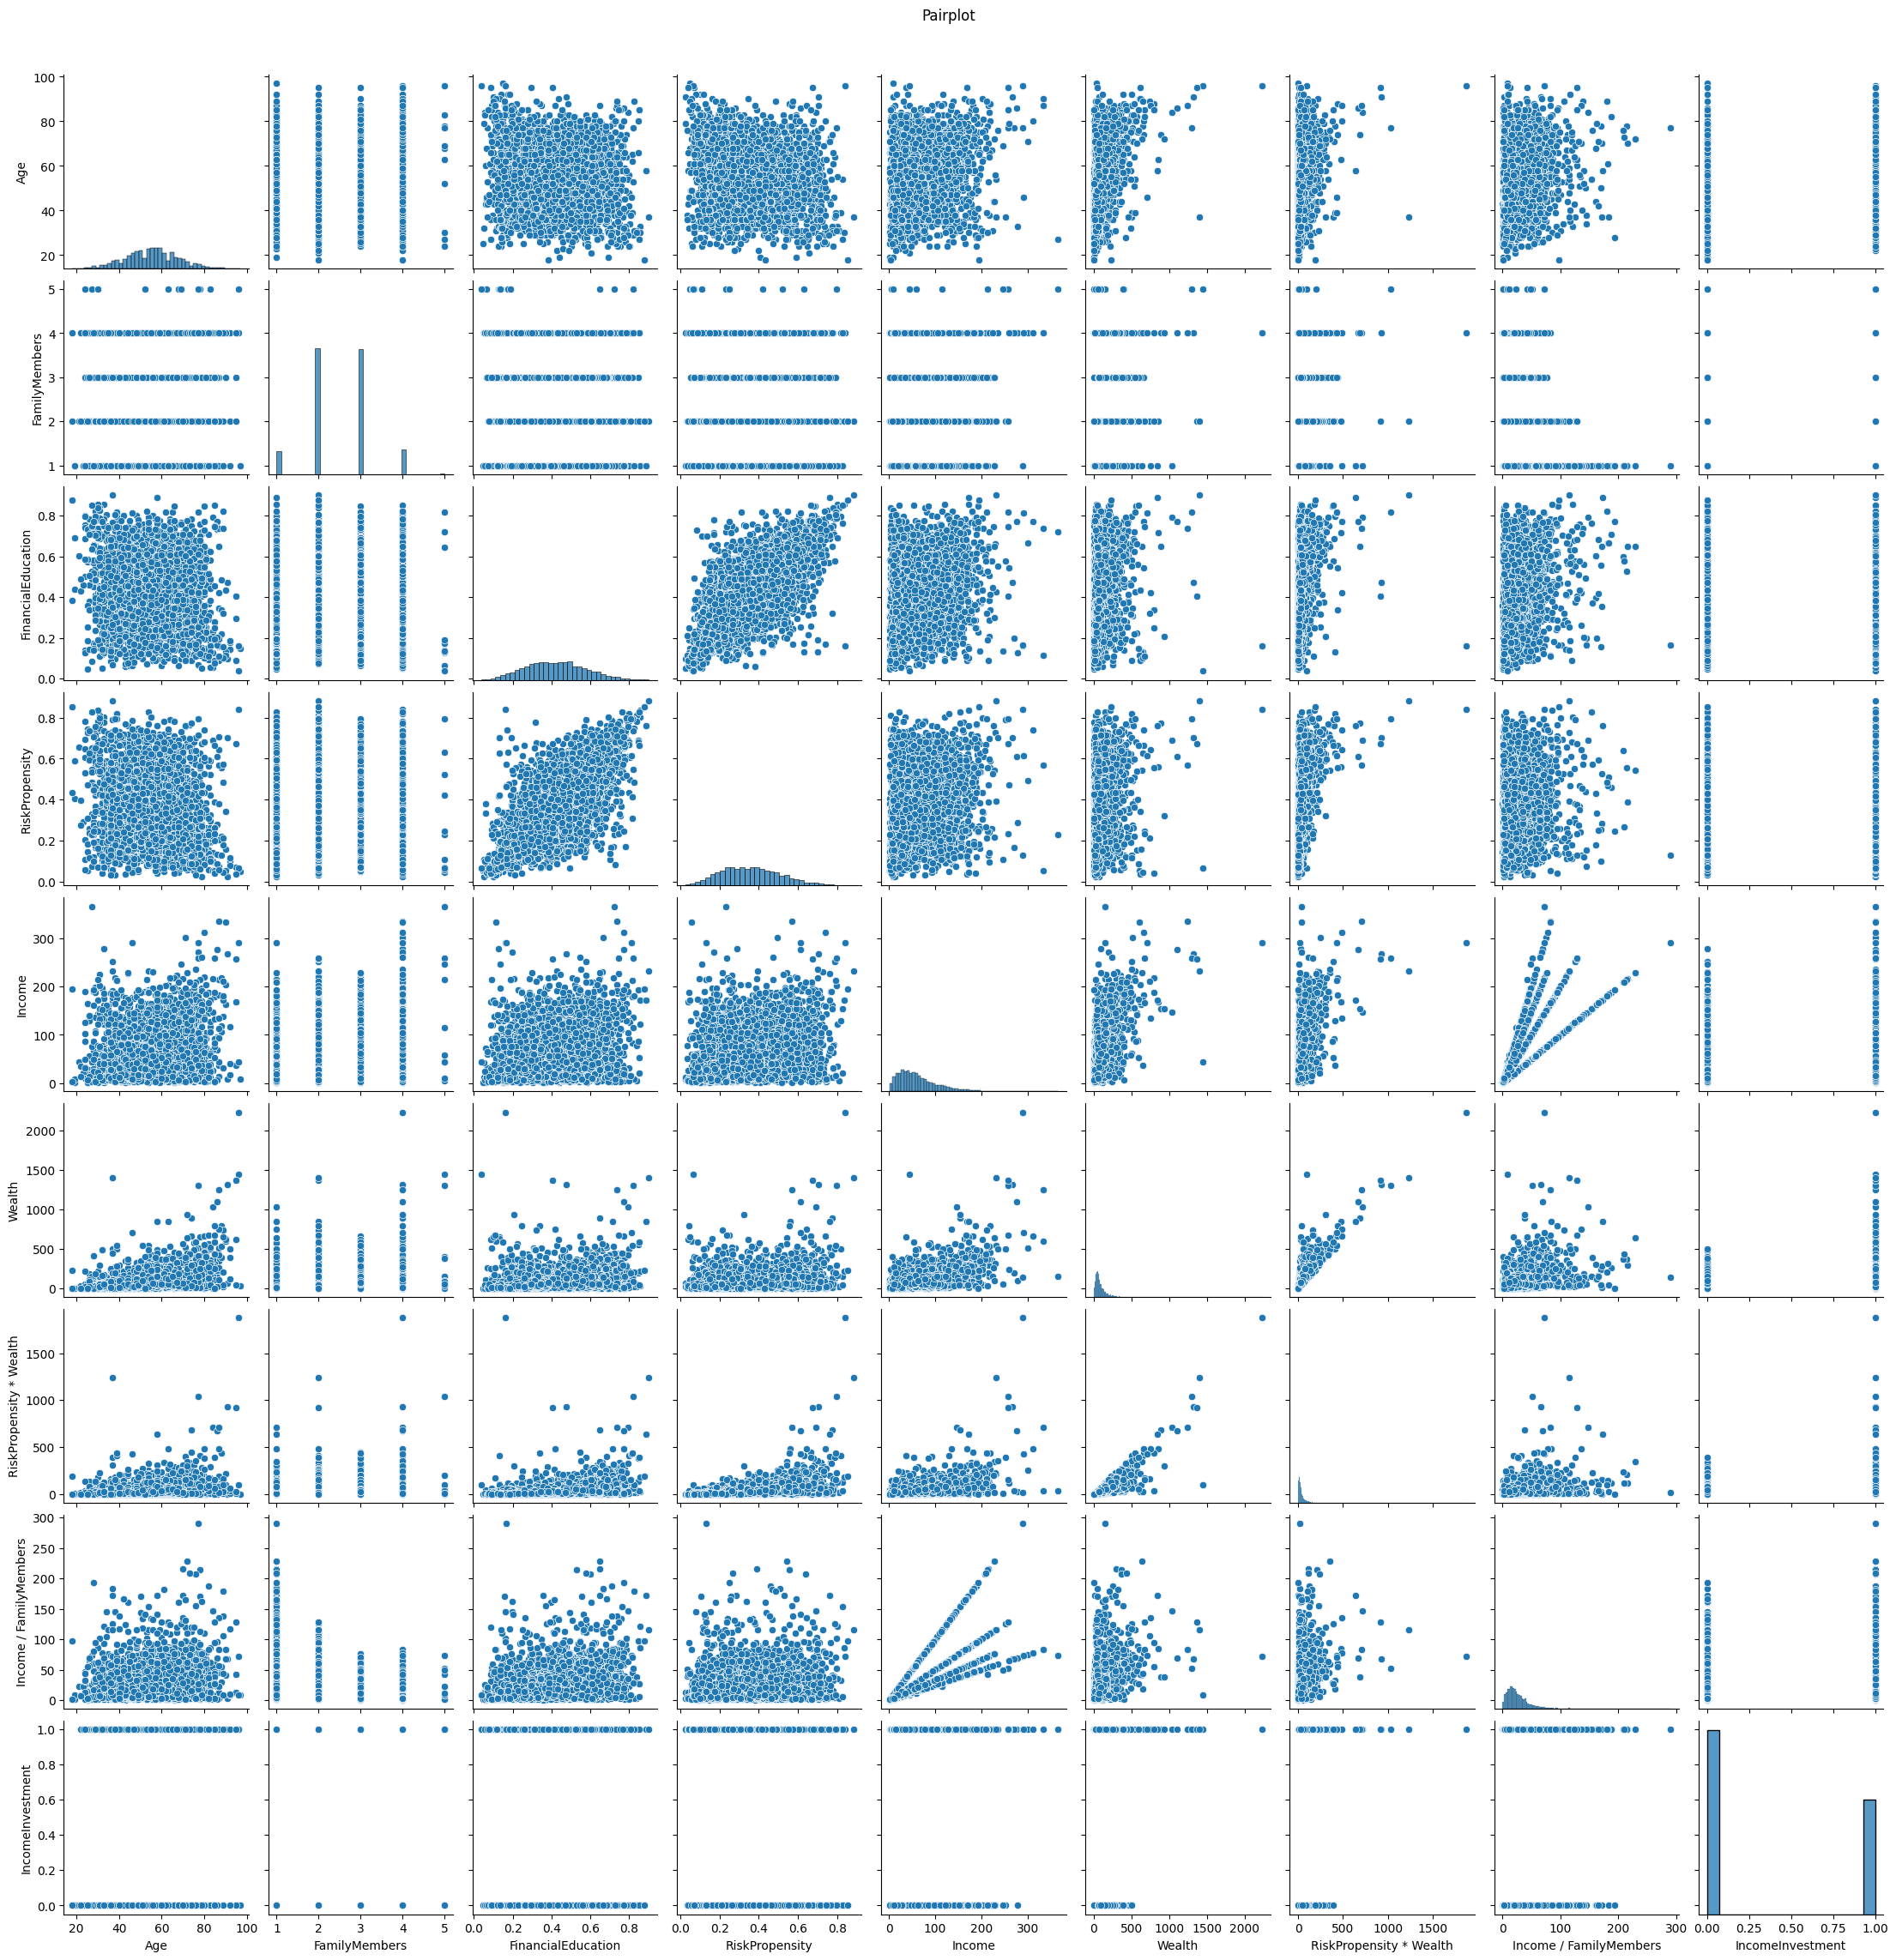

In [308]:
plot_pairplot(df_income)

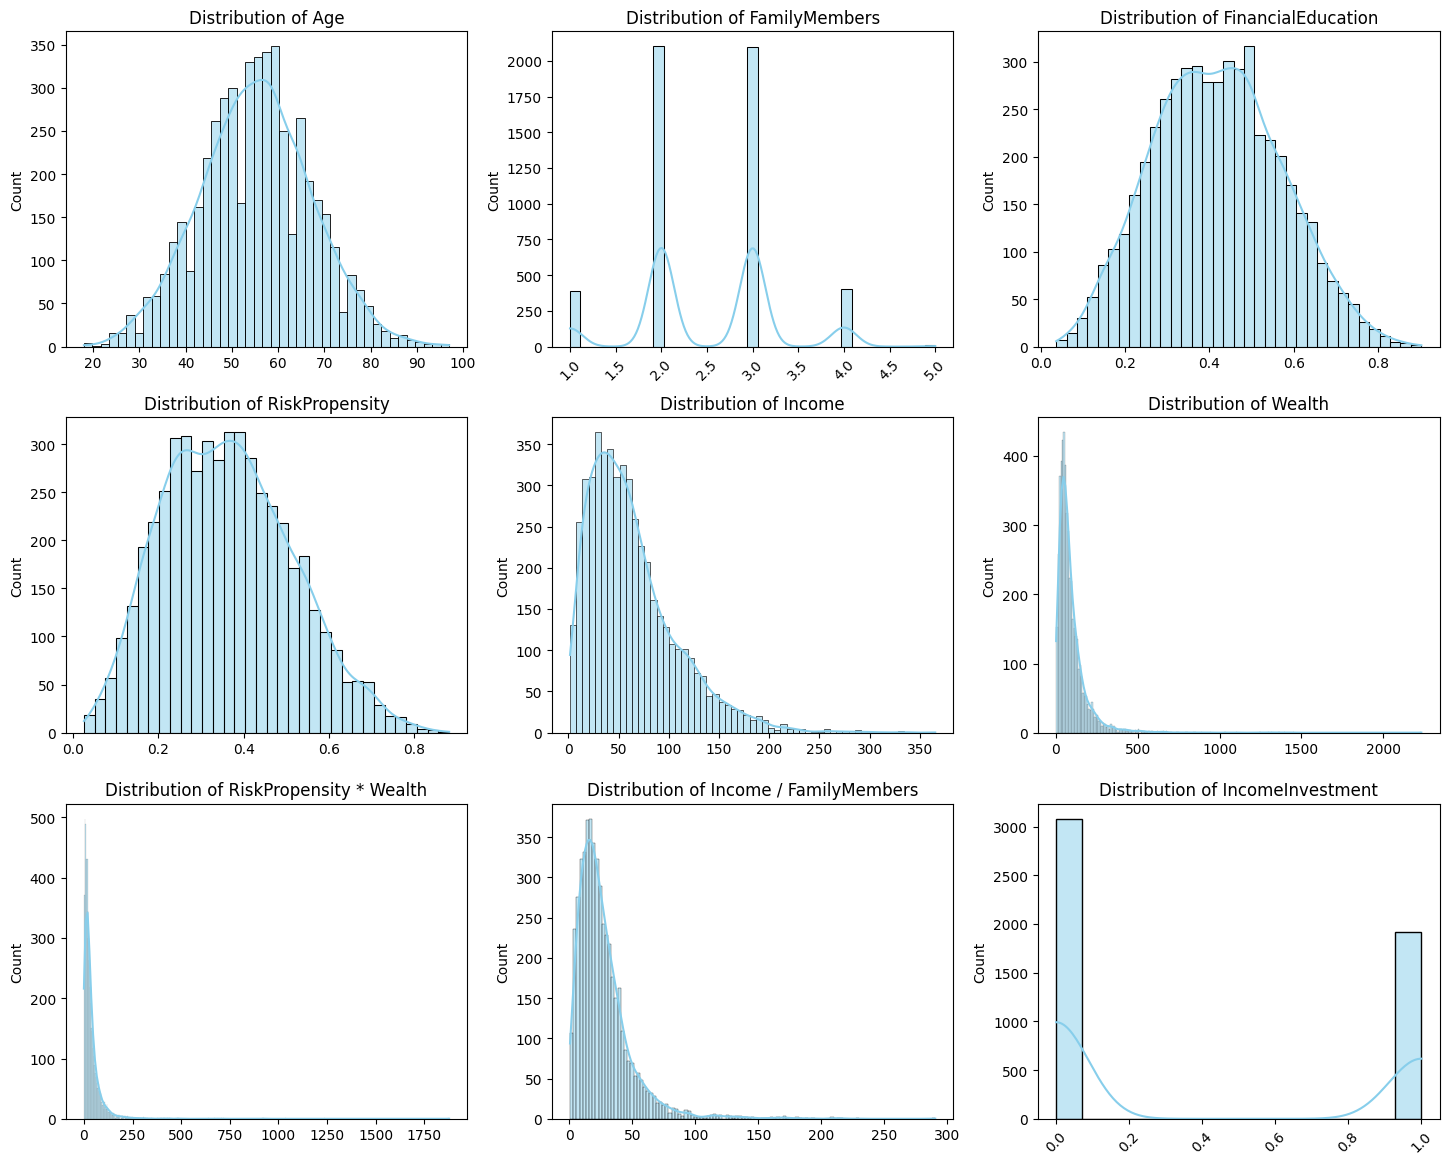

In [309]:
plot_feature_distributions(df_income)

In [ ]:
df_income_transformed = df_income.copy()
pt = PowerTransformer(method='yeo-johnson')
columns_yeo_johnson = df_income_transformed.columns(numerice_only=True)
df_income_transformed[columns_yeo_johnson] = pt.fit_transform(df_income_transformed[columns_yeo_johnson])
plot_feature_distributions(df_income_transformed)

KeyError: "['Wealth / Income', 'RiskPropensity * Income'] not in index"

In [ ]:
scaler = RobustScaler()
numeric_cols = df_income_transformed.select_dtypes(include=['number']).columns.difference(["IncomeInvestment"])
df_income_transformed = df_income_transformed.copy()
df_income_transformed[numeric_cols] = scaler.fit_transform(df_income_transformed[numeric_cols])
df_income_transformed["RiskPropensity"] = needs_df["RiskPropensity"]

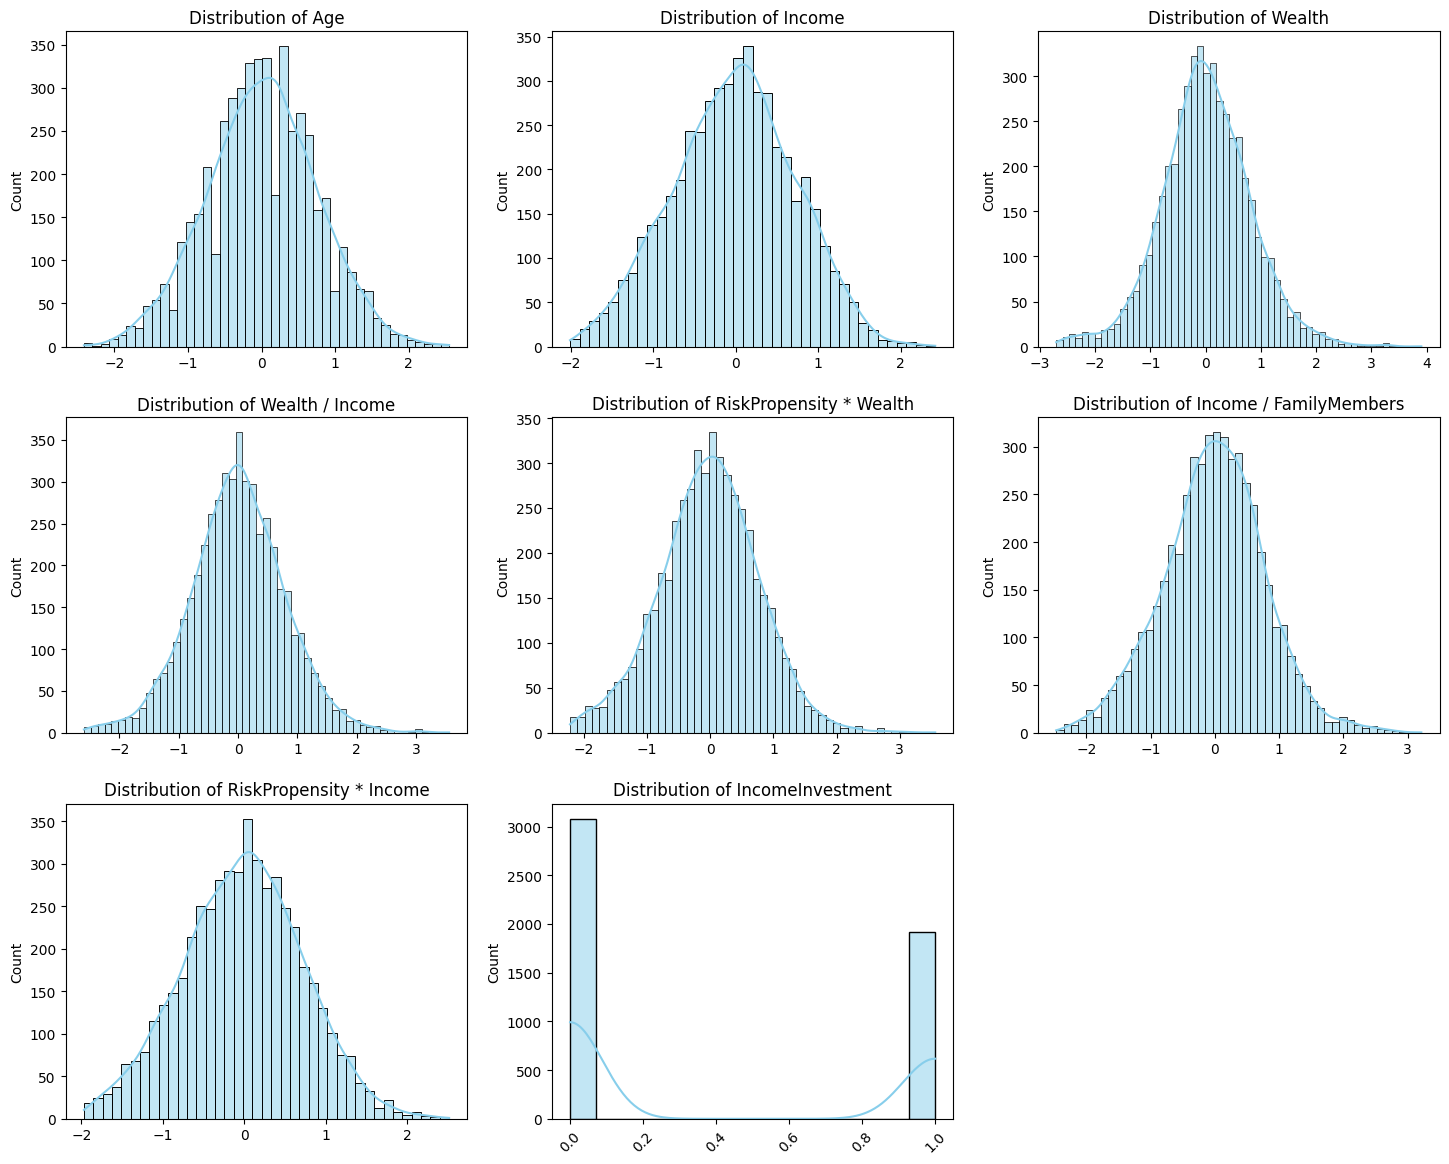

In [ ]:
plot_feature_distributions(df_income_transformed)

In [ ]:
df_income_transformed.to_excel(
    "df_income_transformed.xlsx",
    index=False,
    sheet_name="ProcessedData"  # Optional: customize sheet name
)

In [ ]:
feature_rename_map = {
    'Wealth / Income': 'Wealth_to_income_ratio',
    'RiskPropensity * Wealth': 'risk_weighted_Wealth',
    'Income / FamilyMembers': 'income_per_dependent',
    'RiskPropensity * Income': 'risk_weighted_income'
}

# Apply the renaming
df_income_transformed = df_income_transformed.rename(columns=feature_rename_map)

In [ ]:
df_income_transformed.head()

,Age,Income,Wealth,Wealth_to_income_ratio,risk_weighted_Wealth,income_per_dependent,risk_weighted_income,IncomeInvestment
0,0.311086,0.252633,-0.193803,0.030280,-0.424089,0.482826,-0.088957,0
1,1.412099,-0.793303,0.681875,-0.076322,0.014998,-0.659570,-1.048538,1
2,-1.405255,-0.743314,0.003208,-0.399848,-0.224911,-0.601155,-0.789963,0
3,0.865010,1.307327,1.828994,1.796406,1.902920,0.702960,1.636908,1
4,0.186958,-0.815463,-0.103730,-0.500511,-0.070909,-1.035291,-0.635563,0
